## Differential abundance with Milo

In [1]:
suppressPackageStartupMessages(
{library(SingleCellExperiment)
library(biomaRt)
library(data.table)
library(scater)
library(BiocParallel)
library(scran)
library(miloR)
}
)

In [2]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("miloR")

### 1. Load RDS object 

In [3]:
human_dir <- "/nfs/team292/vl6/FetalReproductiveTract/"

In [4]:
sce <- readRDS(paste0(human_dir, "organoids_BPP_g1.rds"))
sce

class: SingleCellExperiment 
dim: 17659 32274 
metadata(1): log1p
assays(3): X raw_counts log_normalised_counts
rownames(17659): A1BG A1BG-AS1 ... ZZEF1 hsa-mir-423
rowData names(67): GeneID.0 GeneName.0 ... n_cells.9 n_cells
colnames(32274): HD_F_GON15290542_TAGCCGGCAGTCAGCC
  HD_F_GON15290542_TGGGCGTTCCAAACTG ...
  HD_F_GON15290558_GCATGTATCATCGATG HD_F_GON15290558_AGCGTCGCATCAGTCA
colData names(18): n_counts n_genes ... leiden celltype
reducedDimNames(3): PCA UMAP X_pca_harmony
mainExpName: NULL
altExpNames(0):

In [5]:
sce$condition <- factor(sce$condition, levels = c("ctrl_dmso", "BPP"))
levels(sce$condition)

[1] "ctrl_dmso" "BPP"

### 2. Format the SCE object with appropriate slots for raw and normalised counts

In [6]:
assay(sce, "counts") <- assay(sce, "raw_counts")
assay(sce, "logcounts") <- assay(sce, "log_normalised_counts")

In [7]:
sce

class: SingleCellExperiment 
dim: 17659 32274 
metadata(1): log1p
assays(5): X raw_counts log_normalised_counts counts logcounts
rownames(17659): A1BG A1BG-AS1 ... ZZEF1 hsa-mir-423
rowData names(67): GeneID.0 GeneName.0 ... n_cells.9 n_cells
colnames(32274): HD_F_GON15290542_TAGCCGGCAGTCAGCC
  HD_F_GON15290542_TGGGCGTTCCAAACTG ...
  HD_F_GON15290558_GCATGTATCATCGATG HD_F_GON15290558_AGCGTCGCATCAGTCA
colData names(18): n_counts n_genes ... leiden celltype
reducedDimNames(3): PCA UMAP X_pca_harmony
mainExpName: NULL
altExpNames(0):

In [8]:
# Remove unnecessary assay slots 
assay(sce, "X") <- NULL
assay(sce, "raw_counts") <- NULL
assay(sce, "log_normalised_counts") <- NULL

### 3. Create Milo object on Harmony embedding

In [9]:
sce_milo <- Milo(sce)

In [10]:
sce_milo

class: Milo 
dim: 17659 32274 
metadata(1): log1p
assays(2): counts logcounts
rownames(17659): A1BG A1BG-AS1 ... ZZEF1 hsa-mir-423
rowData names(67): GeneID.0 GeneName.0 ... n_cells.9 n_cells
colnames(32274): HD_F_GON15290542_TAGCCGGCAGTCAGCC
  HD_F_GON15290542_TGGGCGTTCCAAACTG ...
  HD_F_GON15290558_GCATGTATCATCGATG HD_F_GON15290558_AGCGTCGCATCAGTCA
colData names(18): n_counts n_genes ... leiden celltype
reducedDimNames(3): PCA UMAP X_pca_harmony
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1

In [11]:
nhoods(sce_milo)
nhoodCounts(sce_milo)
nhoodAdjacency(sce_milo)

1 x 1 diagonal matrix of class "ddiMatrix"
     [,1]
[1,]    0

1 x 1 diagonal matrix of class "ddiMatrix"
     [,1]
[1,]    0

1 x 1 diagonal matrix of class "ddiMatrix"
     [,1]
[1,]    0

In [12]:
k_neigh <- 75
n_comp <- 17
prop_indexCell <- 0.05

In [13]:
sce_milo <- buildGraph(sce_milo, k=k_neigh, d=n_comp, reduced.dim="X_pca_harmony", BPPARAM=MulticoreParam(7))

Constructing kNN graph with k:75



In [14]:
sce_milo <- makeNhoods(sce_milo, prop=prop_indexCell, k=k_neigh, d=n_comp, refined=TRUE, reduced_dims="X_pca_harmony")

Checking valid object



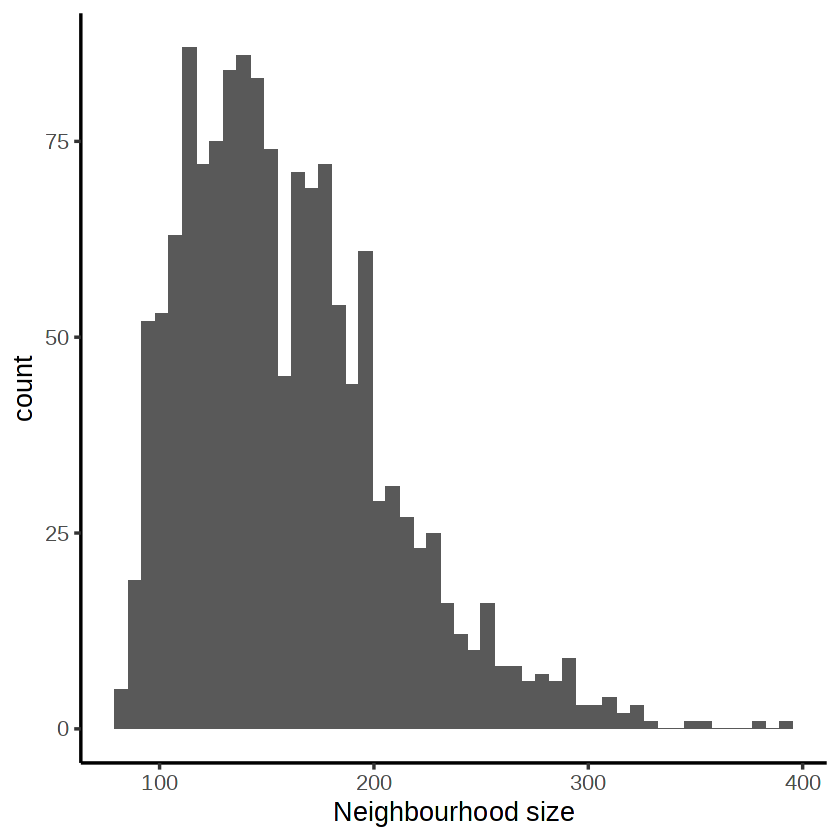

In [15]:
plotNhoodSizeHist(sce_milo)

In [16]:
sce_milo <- countCells(sce_milo, meta.data = data.frame(colData(sce_milo)), sample="sample")

Checking meta.data validity

Counting cells in neighbourhoods



In [17]:
head(nhoodCounts(sce_milo))

6 x 8 sparse Matrix of class "dgCMatrix"
  HD_F_GON15290542 HD_F_GON15290544 HD_F_GON15290547 HD_F_GON15290549
1               89                4               59                4
2               58                6               34                .
3                2                .                4                .
4                .                .                .                .
5               16               21                7               45
6                1                .                8                .
  HD_F_GON15290552 HD_F_GON15290553 HD_F_GON15290556 HD_F_GON15290558
1                6               11                6                2
2                8                6                5                .
3                9               30                2               51
4                .              104                .               40
5                1                5                2                9
6              100               32              

In [18]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, u

In [19]:
sce_design <- data.frame(colData(sce_milo))[,c("sample", "condition")]
## Convert batch info from integer to factor
sce_design <- distinct(sce_design)
rownames(sce_design) <- sce_design$sample

sce_design

,sample,condition
,<fct>,<fct>
HD_F_GON15290542,HD_F_GON15290542,ctrl_dmso
HD_F_GON15290544,HD_F_GON15290544,BPP
HD_F_GON15290547,HD_F_GON15290547,ctrl_dmso
HD_F_GON15290549,HD_F_GON15290549,BPP
HD_F_GON15290552,HD_F_GON15290552,ctrl_dmso
HD_F_GON15290553,HD_F_GON15290553,BPP
HD_F_GON15290556,HD_F_GON15290556,ctrl_dmso
HD_F_GON15290558,HD_F_GON15290558,BPP


In [20]:
sce_milo <- calcNhoodDistance(sce_milo, d=17, reduced.dim = "X_pca_harmony")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [21]:
da_results <- testNhoods(sce_milo, design = ~condition, design.df = sce_design)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



In [22]:
da_results %>%
  arrange(SpatialFDR) %>%
  head()

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
39,8.913784,10.115793,16.65417,0.0003376140,0.008078977,39,0.00775061
69,8.609957,9.831569,16.27227,0.0003831556,0.008078977,69,0.00775061
93,7.914728,9.198521,16.83023,0.0003186130,0.008078977,93,0.00775061
94,8.337760,9.580255,18.05027,0.0002057187,0.008078977,94,0.00775061
106,9.080458,10.273012,17.72898,0.0002282220,0.008078977,106,0.00775061
163,8.599114,9.820868,17.48267,0.0002472614,0.008078977,163,0.00775061


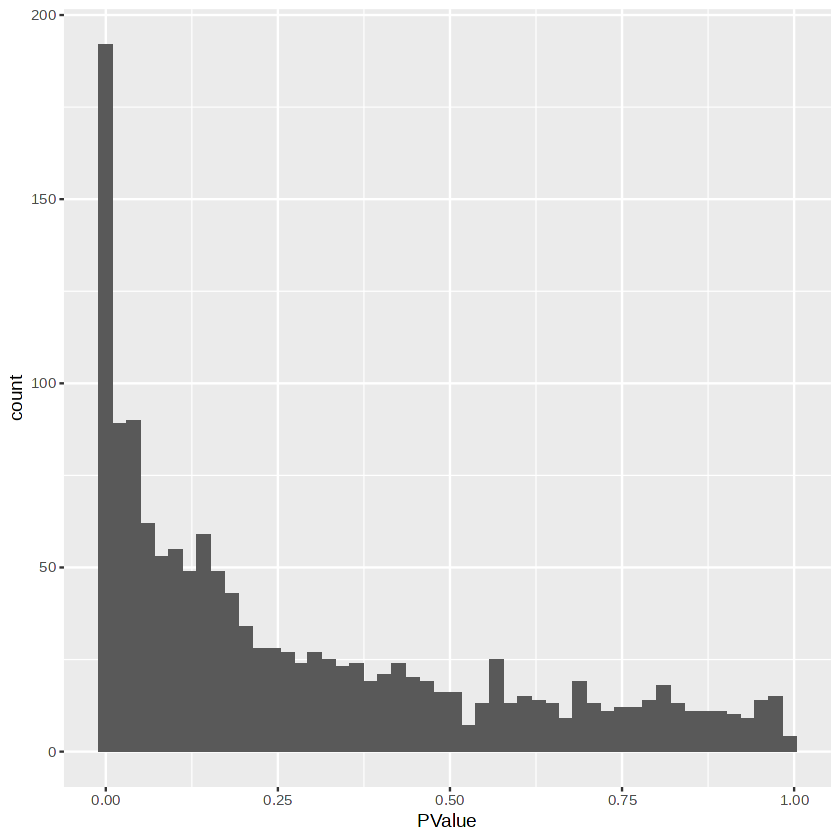

In [23]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

In [24]:
library(patchwork)

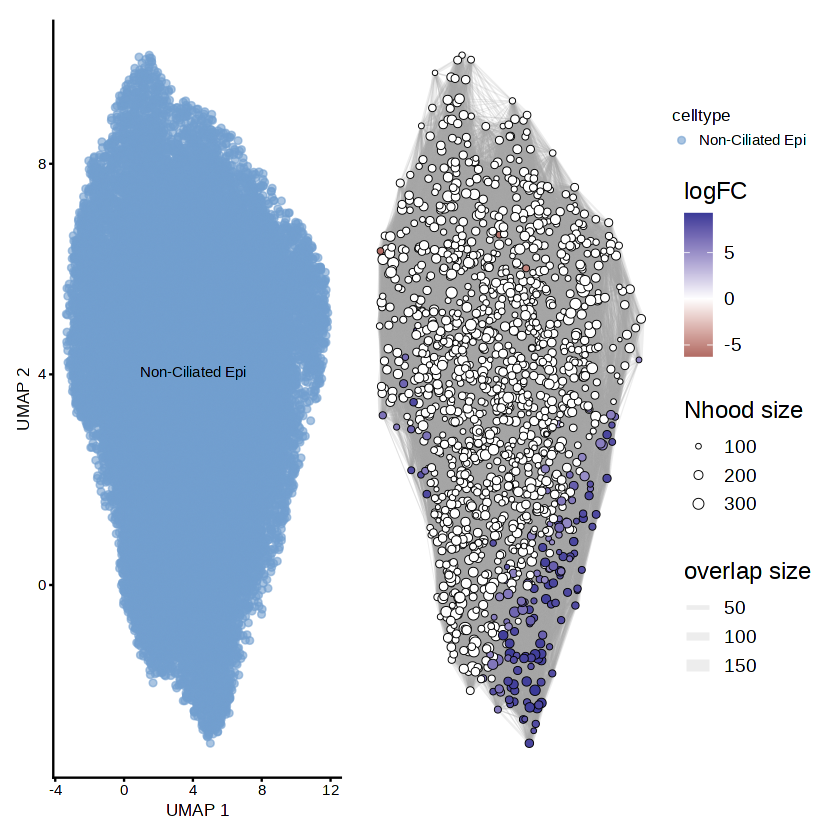

In [25]:
sce_milo <- buildNhoodGraph(sce_milo)

## Plot single-cell UMAP
umap_pl <- plotReducedDim(sce_milo, dimred = "UMAP", colour_by="celltype",
                          text_by = "celltype", text_size = 3) +
  guides(fill="none")

## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(sce_milo, da_results, layout="UMAP",alpha=0.05)

umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [26]:
# Open a PDF file to save the plot with specified width and height
pdf("nh_graph_bpp_g1.pdf", width=8, height=6)  # Width and height are in inches

# Create your plot. Assuming nh_graph_pl is the plot object
print(nh_graph_pl)

# Close the device to save the file
dev.off()

pdf 
  2

In [27]:
da_results <- annotateNhoods(sce_milo, da_results, coldata_col = "leiden")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,leiden,leiden_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-2.302671,9.483462,2.592757,0.117248649,0.29826043,1,0.2953836,4,0.6077348
2,-2.533977,8.945550,2.924766,0.097213689,0.27537423,2,0.2714101,2,0.6752137
3,2.635839,9.145485,2.887233,0.099291162,0.27856070,3,0.2747017,0,0.7755102
4,8.436091,9.670185,13.422756,0.001026139,0.01535968,4,0.0148654,0,0.8263889
5,2.131349,9.142570,2.446685,0.127683518,0.31191395,5,0.3093068,3,0.7641509
6,-1.863216,10.014309,1.218600,0.278123879,0.45668840,6,0.4566338,5,1.0000000


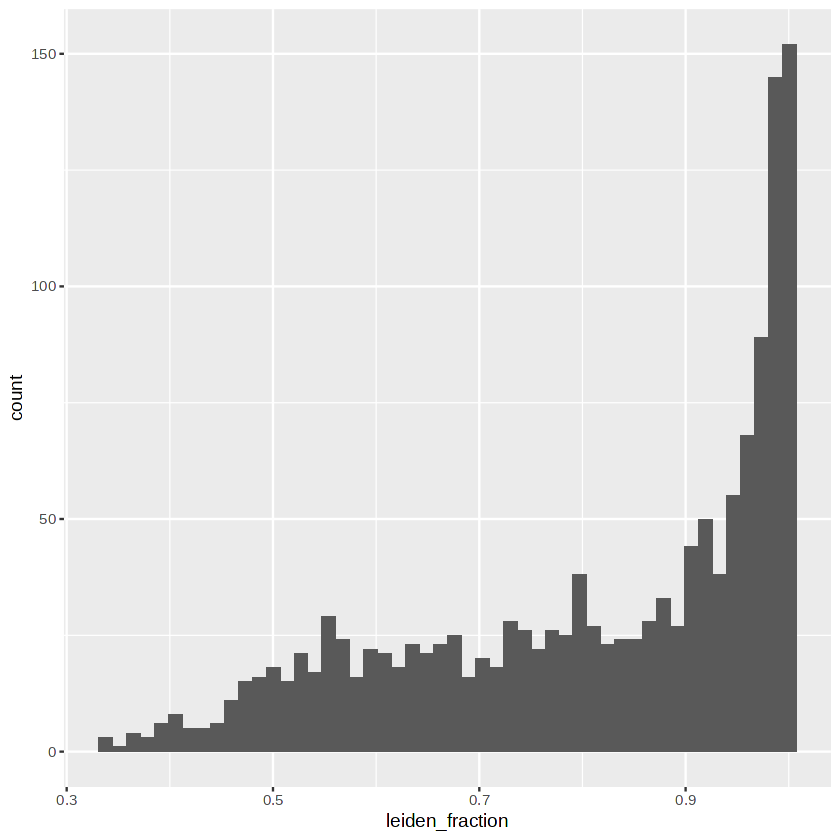

In [28]:
ggplot(da_results, aes(leiden_fraction)) + geom_histogram(bins=50)

Converting group.by to factor...



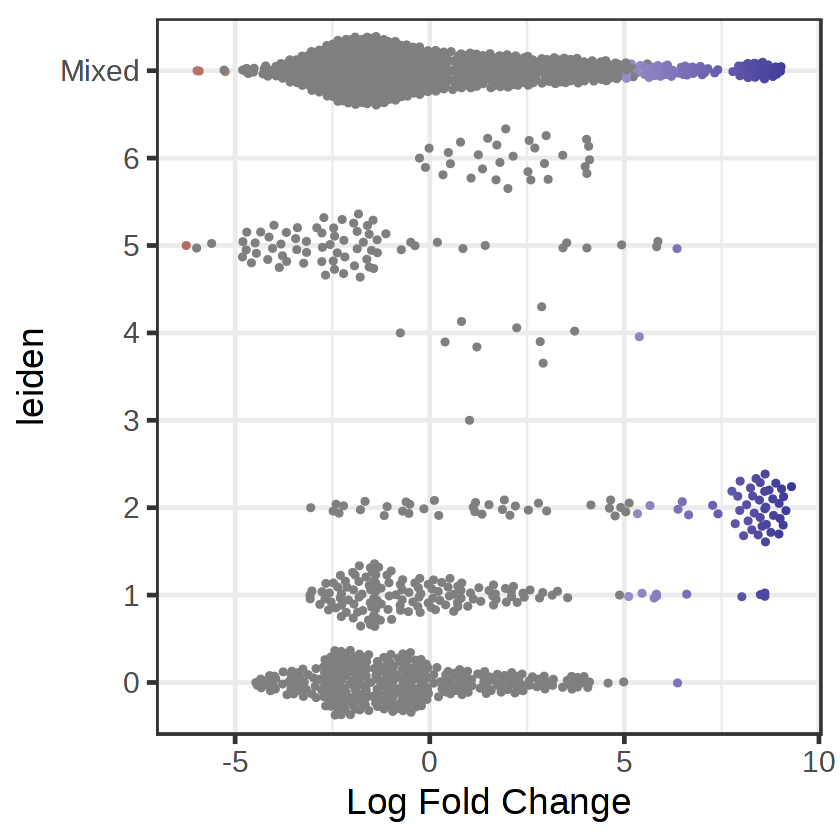

In [29]:
da_results$leiden <- ifelse(da_results$leiden_fraction < 0.9, "Mixed", da_results$leiden)
plotDAbeeswarm(da_results, group.by = "leiden", alpha = 0.05)

In [30]:
da_results$NhoodGroup <- as.numeric(da_results$SpatialFDR < 0.05 & da_results$logFC > 1)

In [31]:
table(da_results$NhoodGroup, da_results$leiden)

   
      0   1   2   3   4   5   6 Mixed
  0 307 129  35   1   9  71  30   692
  1   1  10  44   0   1   1   0    91

In [32]:
da_nhood_markers <- findNhoodGroupMarkers(sce_milo, da_results, 
                                          aggregate.samples = TRUE, sample_col = "sample")

Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message:
“Zero sample variances detected, have been offset away from zero”


In [33]:
library(ggrepel)


In [34]:
markers_up <- da_nhood_markers$GeneID[da_nhood_markers$adj.P.Val_1 < 0.05 & da_nhood_markers$logFC_1 > 0.5]

In [35]:
length(markers_up)

[1] 32

In [36]:
markers_up


[1] "ESR1"     "TPD52L1"  "SCGB1D2"  "CD200"    "COL1A2"   "SELENOP" 
 [7] "SCGB2A1"  "PGR"      "PIK3R1"   "C2orf88"  "PLCB1"    "SOX17"   
[13] "PSAT1"    "ALPL"     "SLC39A6"  "CADM1"    "MMP7"     "ETS2"    
[19] "MPST"     "ASRGL1"   "CERNA2"   "CPM"      "SAT1"     "TMEM101" 
[25] "STX18"    "COL18A1"  "PLA2G12A" "LGR5"     "GRIA2"    "MSX1"    
[31] "CD24"     "DEPTOR"

In [37]:
da_nhood_markers['PGR', ]

,logFC_0,adj.P.Val_0,logFC_1,adj.P.Val_1,GeneID
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
PGR,-0.5027727,1.484045e-05,0.5027727,1.484045e-05,PGR


In [38]:
write.csv(da_nhood_markers, paste0(human_dir, "organoids_BPP_g1_DEGs.csv"))

In [39]:
library(enrichR)


Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!



In [40]:
2+3

[1] 5

In [41]:
# Specify the databases to use
selected_dbs <- c("KEGG_2021_Human", "GO_Biological_Process_2021", "MSigDB_Hallmark_2020")

# Perform enrichment analysis
enrichment_results <- enrichR::enrichr(markers_up, selected_dbs)

Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.


In [42]:
# View results for the KEGG database
kegg_results <- enrichment_results[["KEGG_2021_Human"]]
head(kegg_results)

# View results for the GO Biological Process database
go_results <- enrichment_results[["GO_Biological_Process_2021"]]
head(go_results)

# View results for the GO Biological Process database
msigdb_results <- enrichment_results[["MSigDB_Hallmark_2020"]]
head(msigdb_results)

,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,Estrogen signaling pathway,4/137,6.528168e-05,0.01051035,0,0,21.30505,205.3125,PGR;PIK3R1;PLCB1;ESR1
2,Wnt signaling pathway,4/166,1.372828e-04,0.01105127,0,0,17.46561,155.3298,MMP7;SOX17;PLCB1;LGR5
3,Human T-cell leukemia virus 1 infection,4/219,3.954066e-04,0.01847181,0,0,13.12492,102.8415,MMP7;PIK3R1;MSX1;ETS2
4,AGE-RAGE signaling pathway in diabetic complications,3/100,5.414211e-04,0.01847181,0,0,21.19197,159.3914,COL1A2;PIK3R1;PLCB1
5,Amoebiasis,3/102,5.736586e-04,0.01847181,0,0,20.76176,154.9549,COL1A2;PIK3R1;PLCB1
6,Thyroid hormone signaling pathway,3/121,9.425410e-04,0.02282240,0,0,17.40210,121.2393,PIK3R1;PLCB1;ESR1


,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,intracellular steroid hormone receptor signaling pathway (GO:0030518),3/44,4.712394e-05,0.01983918,0,0,50.27839,500.9100,SCGB2A1;PGR;ESR1
2,insulin-like growth factor receptor signaling pathway (GO:0048009),2/11,1.351792e-04,0.02845522,0,0,147.84444,1317.1327,PIK3R1;PLCB1
3,steroid hormone mediated signaling pathway (GO:0043401),2/15,2.570408e-04,0.03607140,0,0,102.33333,845.9155,PGR;ESR1
4,phosphatidylinositol metabolic process (GO:0046488),3/112,7.532808e-04,0.07456106,0,0,18.84752,135.5339,PLA2G12A;PIK3R1;PLCB1
5,regulation of multicellular organismal development (GO:2000026),2/28,9.134164e-04,0.07456106,0,0,51.13333,357.8474,SOX17;CD24
6,response to estrogen (GO:0043627),2/35,1.427779e-03,0.07456106,0,0,40.27273,263.8522,CD24;ESR1


,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,Estrogen Response Early,4/200,0.0002802069,0.002802069,0,0,14.411079,117.88237,DEPTOR;SLC39A6;PGR;TPD52L1
2,Epithelial Mesenchymal Transition,4/200,0.0002802069,0.002802069,0,0,14.411079,117.88237,COL1A2;CADM1;MSX1;SAT1
3,Androgen Response,2/100,0.0111345221,0.061104888,0,0,13.517007,60.79551,SELENOP;SAT1
4,PI3K/AKT/mTOR Signaling,2/105,0.0122209775,0.061104888,0,0,12.857605,56.63262,PLA2G12A;PLCB1
5,Xenobiotic Metabolism,2/200,0.0405554933,0.101388733,0,0,6.656566,21.33485,ESR1;ETS2
6,TNF-alpha Signaling via NF-kB,2/200,0.0405554933,0.101388733,0,0,6.656566,21.33485,SAT1;ETS2


In [42]:
# Filter results with adjusted p-value < 0.05
filtered_kegg <- kegg_results[kegg_results$Adjusted.P.value < 0.05, ]
filtered_go <- go_results[go_results$Adjusted.P.value < 0.05, ]
filtered_msigdb <- msigdb_results[msigdb_results$Adjusted.P.value < 0.05, ]

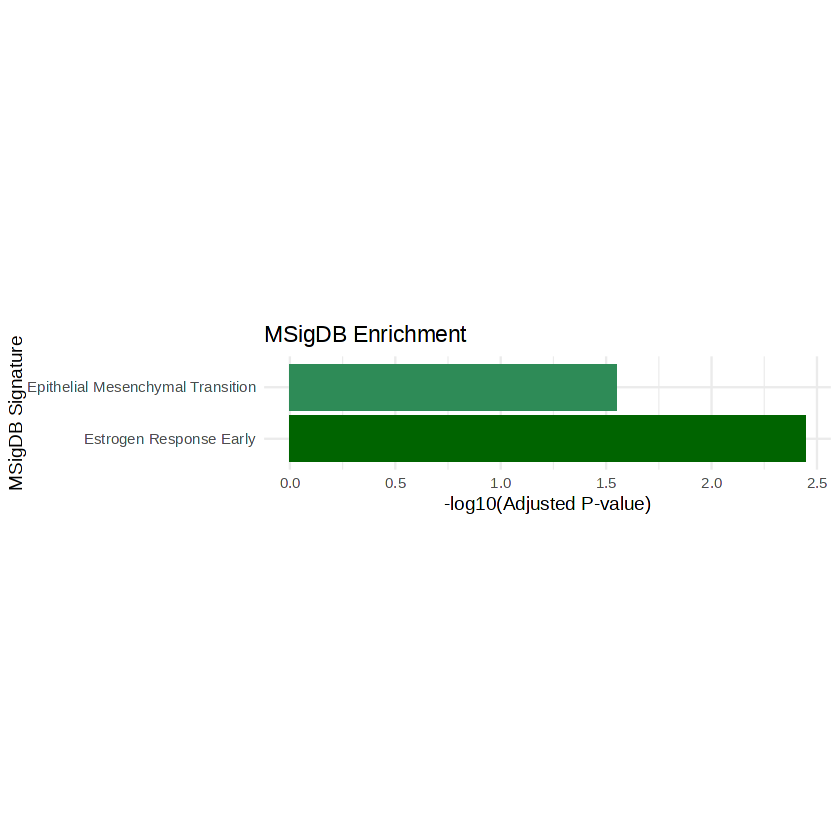

In [50]:
# Subset data to include only the top 5 GO terms by adjusted p-value
top_go_terms <- filtered_msigdb[order(filtered_msigdb$Adjusted.P.value), ][1:2, ]

# Generate a palette of blue shades for the bars
blue_shades <- c( "seagreen", "darkgreen")  # Custom blue shades

# Create the bar plot for the top 5 GO terms
ggplot(top_go_terms, aes(x = reorder(Term, Adjusted.P.value), y = -log10(Adjusted.P.value), fill = Term)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Flips the coordinates for a horizontal bar plot
  scale_fill_manual(values = blue_shades) +  # Apply custom blue shades
  labs(
    title = "MSigDB Enrichment",
    x = "MSigDB Signature",
    y = "-log10(Adjusted P-value)"
  ) +
  theme_minimal() +
  theme(
    aspect.ratio = 1/5,
    legend.position = "none"  # Remove legend
  )
# Save the plot as a PDF with specified dimensions
ggsave("GO_BPP.pdf", width = 10, height = 6, dpi = 300)